In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 2.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Using our merged dataset (train & val), alongside our given test data

This Task is task 2 (SEB VS NEVUS AND MEL). PLEASE USE APPROPRIATE PATH TO TASK
2

In [3]:
#please set title for saving model correctly!!!
title = "seb_vs_nev&mel_aug"

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [6]:
os.listdir('/content')

['.config', 'drive', 'sample_data']

In [7]:
#Initilaizing ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 5s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [8]:
# Add additional layers after the Vision Transformer

model = tensorflow.keras.Sequential([
    vit_model,
    Flatten(),
    Dense(128, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(32, activation=gelu),
    Dropout(0.1),
    LayerNormalization(epsilon=.000002),
    Dense(2, activation='softmax')
], name='vision_transformer')



model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 layer_normalization (LayerN  (None, 128)              256       
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# compiling model using adam optimizer and focal loss
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2) #configuring early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                  #configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [11]:
#function for plotting train and validation accuracy
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation
    # Calculate confusion matrix CHANGE THIS TO CM
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)    #classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #calculating precision

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
# Set the directories for the data for task1 (MEL VS NEVUS AND SEB)
train_dir = "/content/drive/MyDrive/msc_project/train_merged_augumented/task2"
test_dir = "/content/drive/MyDrive/msc_project/test/task2"

In [14]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [15]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=False, random_state=None)

In [16]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0492 - accuracy: 0.8356
Epoch 1: val_accuracy improved from -inf to 0.85385, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_1.hdf5
104/104 [==============================] - 1105s 10s/step - loss: 0.0492 - accuracy: 0.8356 - val_loss: 0.0403 - val_accuracy: 0.8538 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.8856
Epoch 2: val_accuracy did not improve from 0.85385
104/104 [==============================] - 916s 9s/step - loss: 0.0281 - accuracy: 0.8856 - val_loss: 0.0443 - val_accuracy: 0.

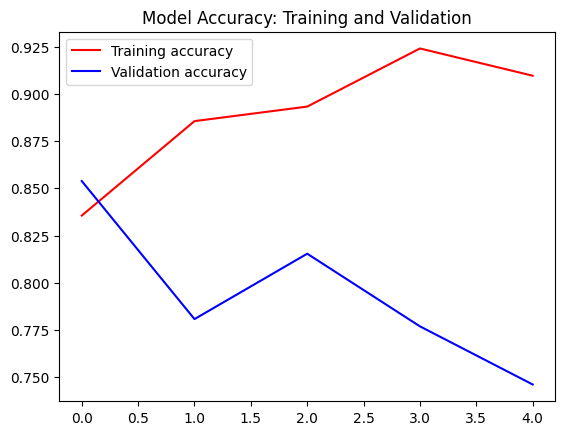

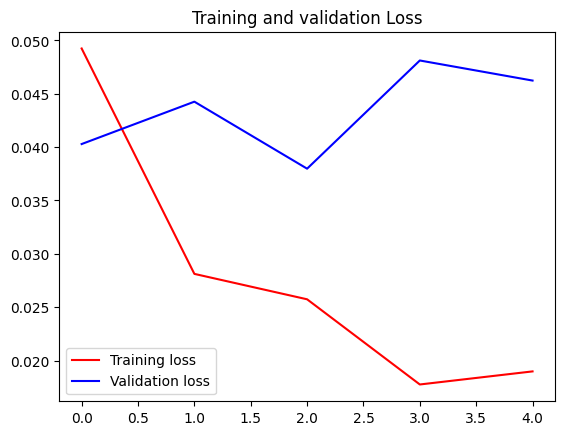

<Figure size 640x480 with 0 Axes>

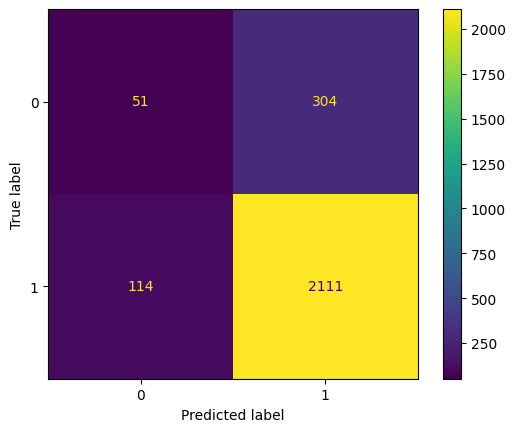


               precision    recall  f1-score   support

           0       0.31      0.14      0.20       355
           1       0.87      0.95      0.91      2225

    accuracy                           0.84      2580
   macro avg       0.59      0.55      0.55      2580
weighted avg       0.80      0.84      0.81      2580

Sensitivity: 0.949 Specificity: 0.144 Precision: 0.796 ROC_AUC_SCORE: 0.772



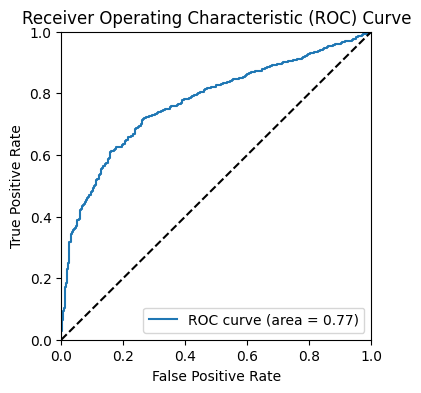

Validation complete...
Traning for Fold: 2
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0325 - accuracy: 0.8615
Epoch 1: val_accuracy improved from -inf to 0.89231, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_2.hdf5
104/104 [==============================] - 572s 5s/step - loss: 0.0325 - accuracy: 0.8615 - val_loss: 0.0200 - val_accuracy: 0.8923 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.8731
Epoch 2: val_accuracy improved from 0.89231 to 0.91154, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_2.hdf5
104/104

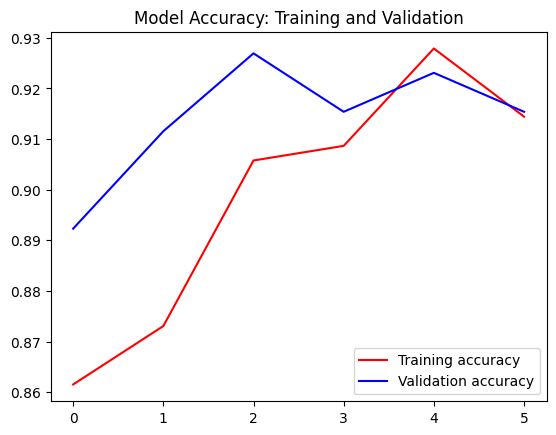

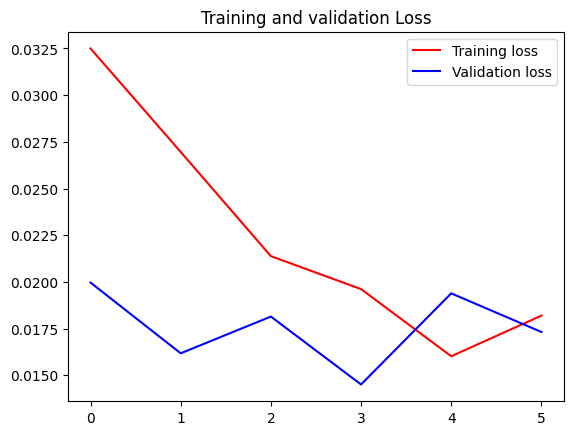

<Figure size 640x480 with 0 Axes>

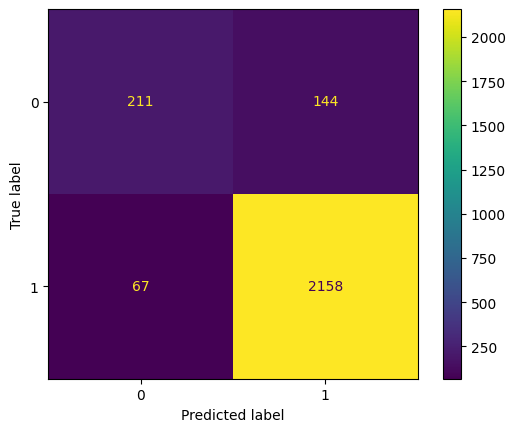


               precision    recall  f1-score   support

           0       0.76      0.59      0.67       355
           1       0.94      0.97      0.95      2225

    accuracy                           0.92      2580
   macro avg       0.85      0.78      0.81      2580
weighted avg       0.91      0.92      0.91      2580

Sensitivity: 0.97 Specificity: 0.594 Precision: 0.913 ROC_AUC_SCORE: 0.954



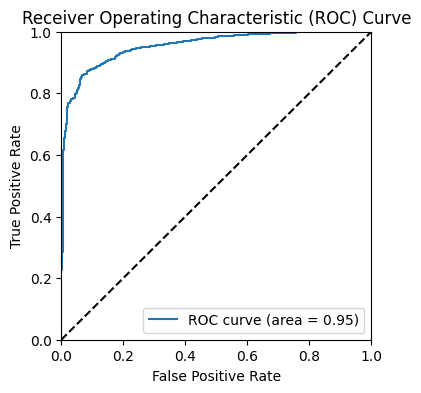

Validation complete...
Traning for Fold: 3
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0230 - accuracy: 0.8885
Epoch 1: val_accuracy improved from -inf to 0.90385, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_3.hdf5
104/104 [==============================] - 267s 2s/step - loss: 0.0230 - accuracy: 0.8885 - val_loss: 0.0205 - val_accuracy: 0.9038 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9077
Epoch 2: val_accuracy did not improve from 0.90385
104/104 [==============================] - 191s 2s/step - loss: 0.0188 - accuracy: 0.9077 - val_loss: 0.02

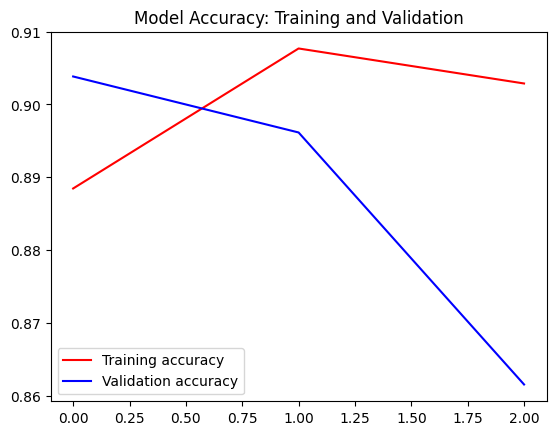

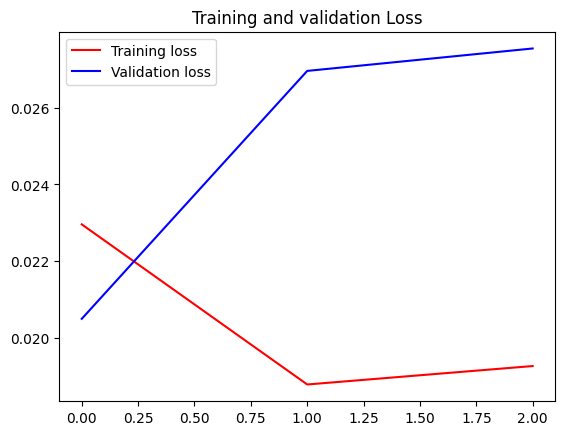

<Figure size 640x480 with 0 Axes>

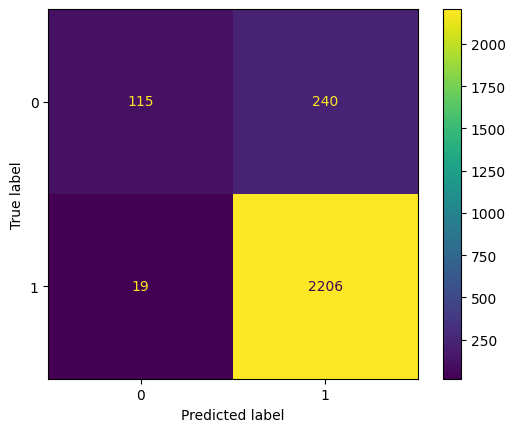


               precision    recall  f1-score   support

           0       0.86      0.32      0.47       355
           1       0.90      0.99      0.94      2225

    accuracy                           0.90      2580
   macro avg       0.88      0.66      0.71      2580
weighted avg       0.90      0.90      0.88      2580

Sensitivity: 0.991 Specificity: 0.324 Precision: 0.896 ROC_AUC_SCORE: 0.934



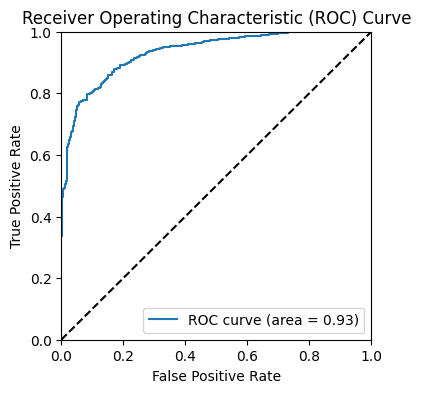

Validation complete...
Traning for Fold: 4
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0212 - accuracy: 0.9000
Epoch 1: val_accuracy improved from -inf to 0.94231, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_4.hdf5
104/104 [==============================] - 182s 1s/step - loss: 0.0212 - accuracy: 0.9000 - val_loss: 0.0119 - val_accuracy: 0.9423 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9346
Epoch 2: val_accuracy improved from 0.94231 to 0.95385, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_4.hdf5
104/104

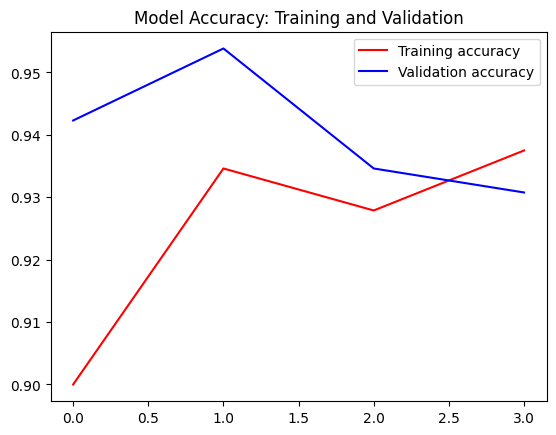

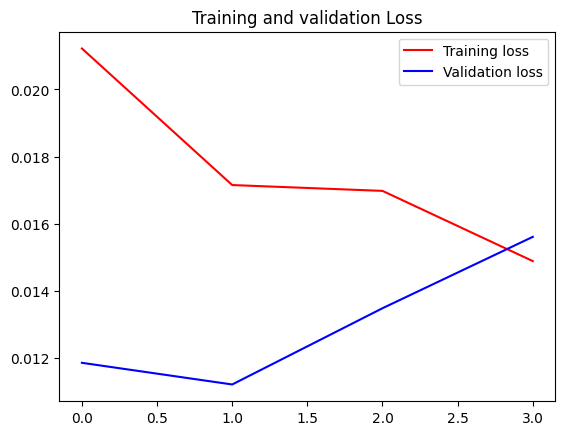

<Figure size 640x480 with 0 Axes>

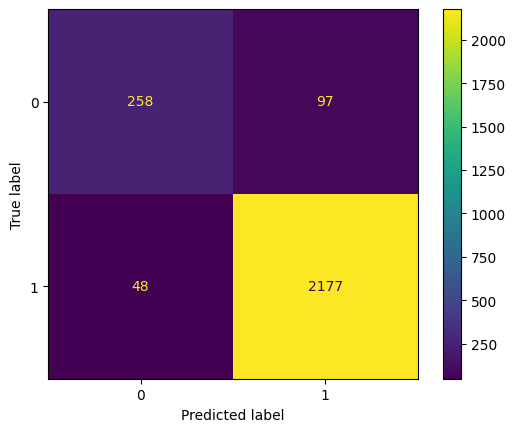


               precision    recall  f1-score   support

           0       0.84      0.73      0.78       355
           1       0.96      0.98      0.97      2225

    accuracy                           0.94      2580
   macro avg       0.90      0.85      0.87      2580
weighted avg       0.94      0.94      0.94      2580

Sensitivity: 0.978 Specificity: 0.727 Precision: 0.942 ROC_AUC_SCORE: 0.974



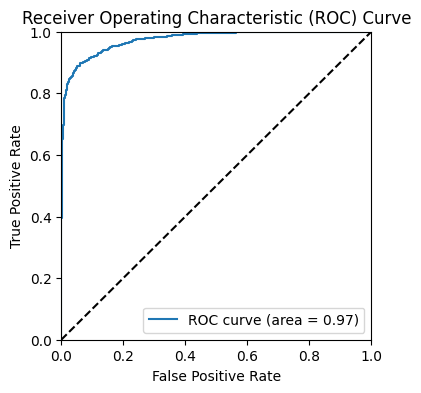

Validation complete...
Traning for Fold: 5
Found 10320 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.
Found 2580 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/10
104/104 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9375
Epoch 1: val_accuracy improved from -inf to 0.94231, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_5.hdf5
104/104 [==============================] - 138s 842ms/step - loss: 0.0133 - accuracy: 0.9375 - val_loss: 0.0129 - val_accuracy: 0.9423 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/10
104/104 [==============================] - ETA: 0s - loss: 0.0153 - accuracy: 0.9385
Epoch 2: val_accuracy improved from 0.94231 to 0.96538, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev&mel_aug/model_fold_5.hdf5
104/

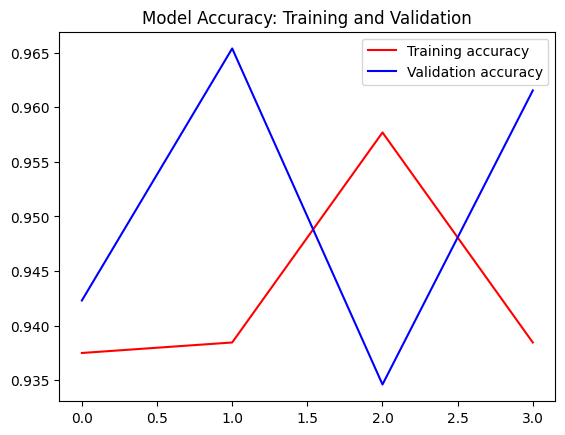

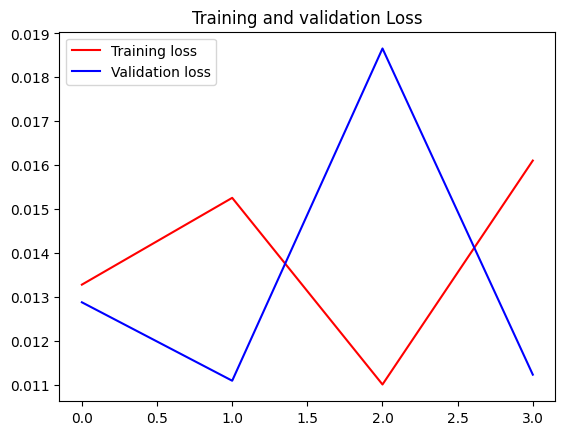

<Figure size 640x480 with 0 Axes>

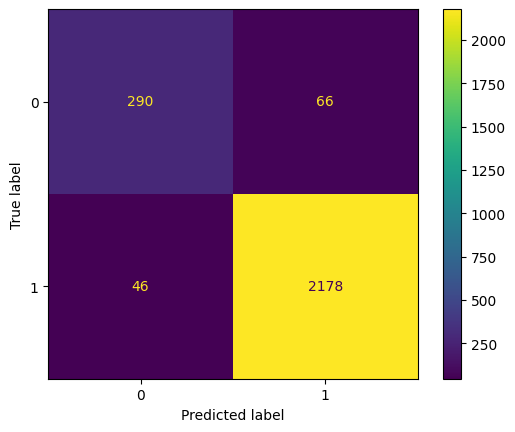


               precision    recall  f1-score   support

           0       0.86      0.81      0.84       356
           1       0.97      0.98      0.97      2224

    accuracy                           0.96      2580
   macro avg       0.92      0.90      0.91      2580
weighted avg       0.96      0.96      0.96      2580

Sensitivity: 0.979 Specificity: 0.815 Precision: 0.956 ROC_AUC_SCORE: 0.978



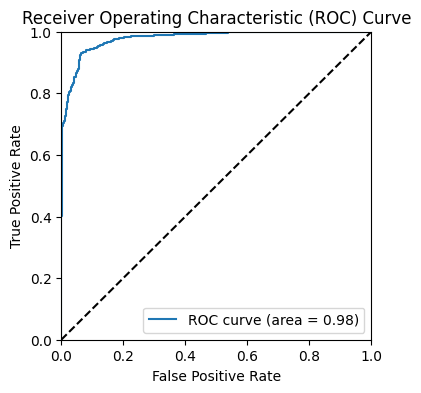

Validation complete...


In [17]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )


    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #please set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(
        optimizer='adam',
        loss=focal_loss(),
        metrics=['accuracy']
    )

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=10,
        callbacks=callbacks)

    #plot train and validation accuracy and loss
    graph_it(history)

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


In [18]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

Found 600 images belonging to 2 classes.


Test using model 1
600/600 [==============================] - 28s 46ms/step


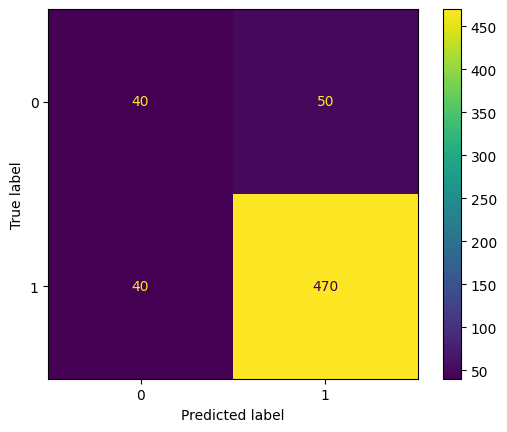


               precision    recall  f1-score   support

           0       0.50      0.44      0.47        90
           1       0.90      0.92      0.91       510

    accuracy                           0.85       600
   macro avg       0.70      0.68      0.69       600
weighted avg       0.84      0.85      0.85       600

Sensitivity: 0.922 Specificity: 0.444 Precision: 0.843 ROC_AUC_SCORE: 0.824



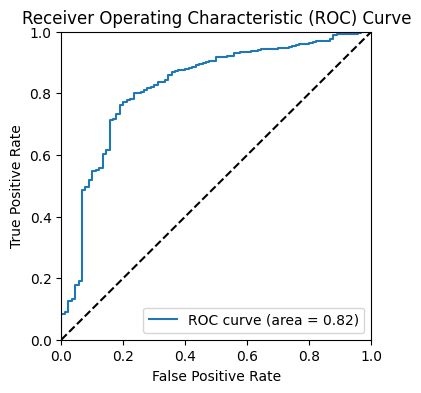

Testing Complete
Test using model 2
600/600 [==============================] - 27s 46ms/step


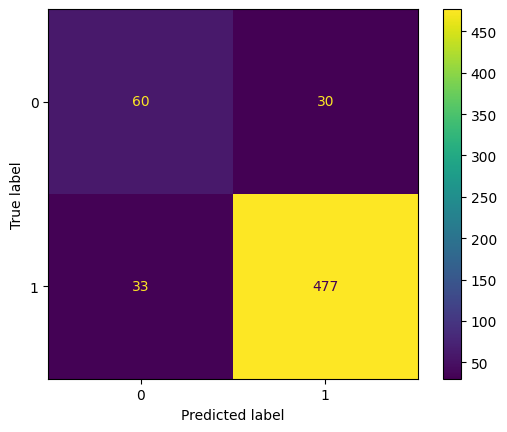


               precision    recall  f1-score   support

           0       0.65      0.67      0.66        90
           1       0.94      0.94      0.94       510

    accuracy                           0.90       600
   macro avg       0.79      0.80      0.80       600
weighted avg       0.90      0.90      0.90       600

Sensitivity: 0.935 Specificity: 0.667 Precision: 0.896 ROC_AUC_SCORE: 0.901



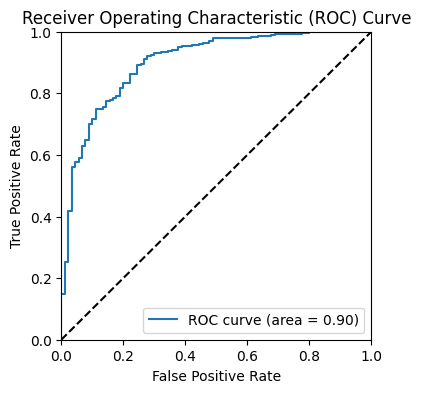

Testing Complete
Test using model 3
600/600 [==============================] - 27s 46ms/step


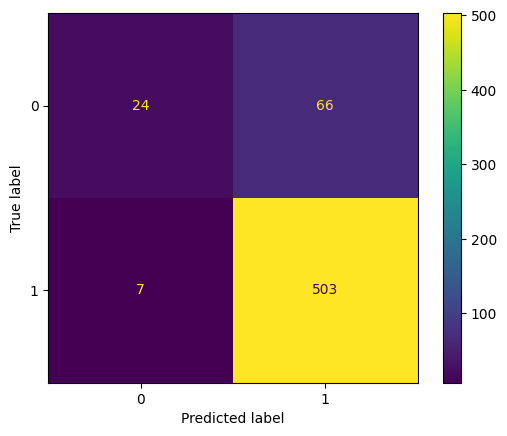


               precision    recall  f1-score   support

           0       0.77      0.27      0.40        90
           1       0.88      0.99      0.93       510

    accuracy                           0.88       600
   macro avg       0.83      0.63      0.66       600
weighted avg       0.87      0.88      0.85       600

Sensitivity: 0.986 Specificity: 0.267 Precision: 0.868 ROC_AUC_SCORE: 0.878



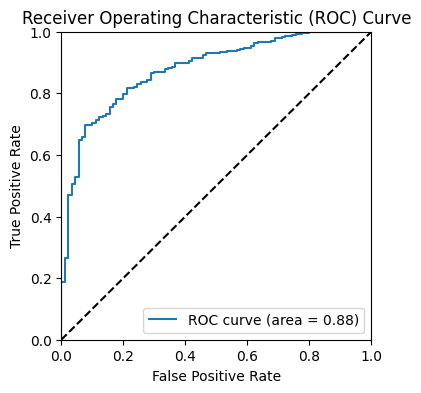

Testing Complete
Test using model 4
600/600 [==============================] - 28s 46ms/step


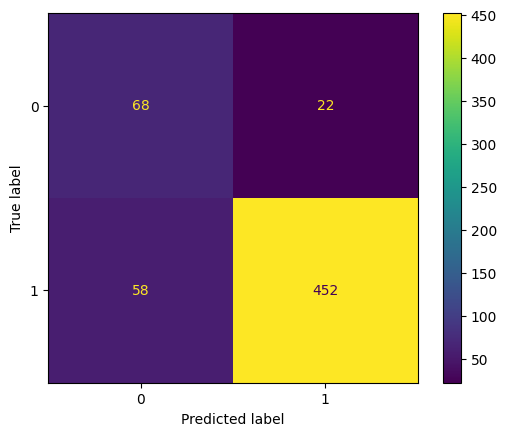


               precision    recall  f1-score   support

           0       0.54      0.76      0.63        90
           1       0.95      0.89      0.92       510

    accuracy                           0.87       600
   macro avg       0.75      0.82      0.77       600
weighted avg       0.89      0.87      0.88       600

Sensitivity: 0.886 Specificity: 0.756 Precision: 0.892 ROC_AUC_SCORE: 0.897



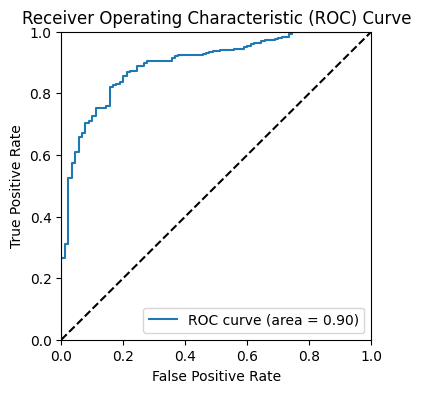

Testing Complete
Test using model 5
600/600 [==============================] - 29s 48ms/step


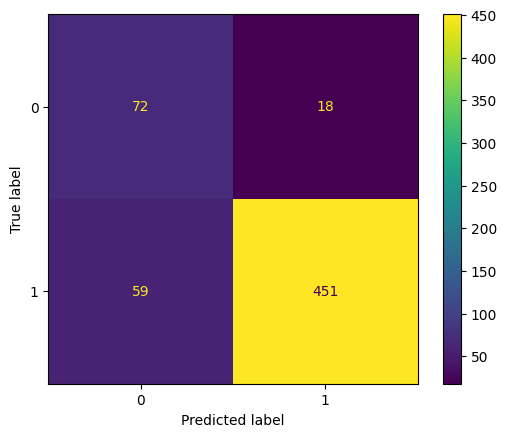


               precision    recall  f1-score   support

           0       0.55      0.80      0.65        90
           1       0.96      0.88      0.92       510

    accuracy                           0.87       600
   macro avg       0.76      0.84      0.79       600
weighted avg       0.90      0.87      0.88       600

Sensitivity: 0.884 Specificity: 0.8 Precision: 0.9 ROC_AUC_SCORE: 0.9



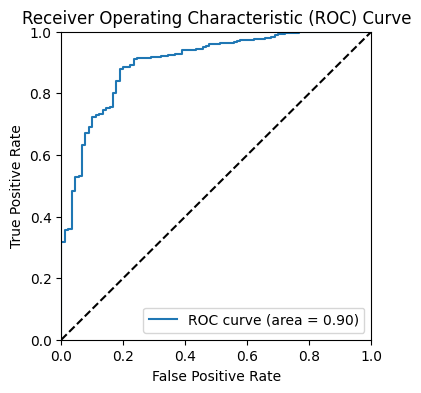

Testing Complete


In [21]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")